In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
diabetes_df = pd.read_csv('diabetes_prediction_dataset.csv')

## Exploration of Data

In [3]:
diabetes_df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
diabetes_df.info() #Displays the information of the dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [5]:
diabetes_df.describe() #Gives statistical data

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [6]:
diabetes_df.isnull().sum() #checks for missing/null values

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [7]:
diabetes_df.duplicated().sum() #checks for duplicate values

3854

In [8]:
#Encode categorical variables (gender, smoknig history)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

categorical_columns = ['gender', 'smoking_history']
for column in categorical_columns:
    diabetes_df[column] = LabelEncoder().fit_transform(diabetes_df[column])

In [9]:
# This function checks for anomalies and outputs the number of each anomaly per category if there are anomalies.
#
# Parameters:
# - Dataset,          type=pandas.dataframe
# - Quantile list,    type=list of floats   (Optional, default=[0.25, 0.50, 0.75]) 
#
# Returns:
# - Anomaly presence, type=boolean

def check_anomalies(dataset, quantile_list=[0.25, 0.50, 0.75]):
    # The quantiles are loaded from the quantile list.
    low = quantile_list[0]
    mid = quantile_list[1]
    top = quantile_list[2]
    
    # The function assumes that there are no anomalies in the dataset until proven otherwise.
    anomaly_presence = False
    
    for category in dataset:
        # Checks if the current category contains exclusively numerical data.
        # If the first entry in a category is a string, then that category is skipped to prevent a value error.
        try:
            if (type(dataset[category][0]) is str):
                continue
        except:
            pass
        
        # Calculating the quantiles.
        Q1 = dataset[category].quantile(low)
        Q2 = dataset[category].quantile(mid)
        Q3 = dataset[category].quantile(top)
        IQR = Q3 - Q1

        # Calculating the bounds.
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        # Checking for anomalies.
        anomalies = dataset[(dataset[category] < lower_bound) | (dataset[category] > upper_bound)]
        if (anomalies.shape[0] > 1):
            anomaly_presence = True
            print("There are " + str(anomalies.shape[0]) + " " + category + " anomalies in this dataset.")
        elif (anomalies.shape[0] == 1):
            anomaly_presence = True
            print("There is " + str(anomalies.shape[0]) + " " + category + " anomaly in this dataset.")
    
    # If there is no anomaly in the dataset, the user is informed of the lack of anomalies.
    if (anomaly_presence == False):
        print("There are no anomalies in the dataset.  Hooray!")
        
    # The function returns whether it found anomalies.
    return anomaly_presence
        
# The anomalies for the diabetes dataset are checked using the defeault settings.
check_anomalies(diabetes_df)

There are 7485 hypertension anomalies in this dataset.
There are 3942 heart_disease anomalies in this dataset.
There are 7086 bmi anomalies in this dataset.
There are 1315 HbA1c_level anomalies in this dataset.
There are 2038 blood_glucose_level anomalies in this dataset.
There are 8500 diabetes anomalies in this dataset.


True

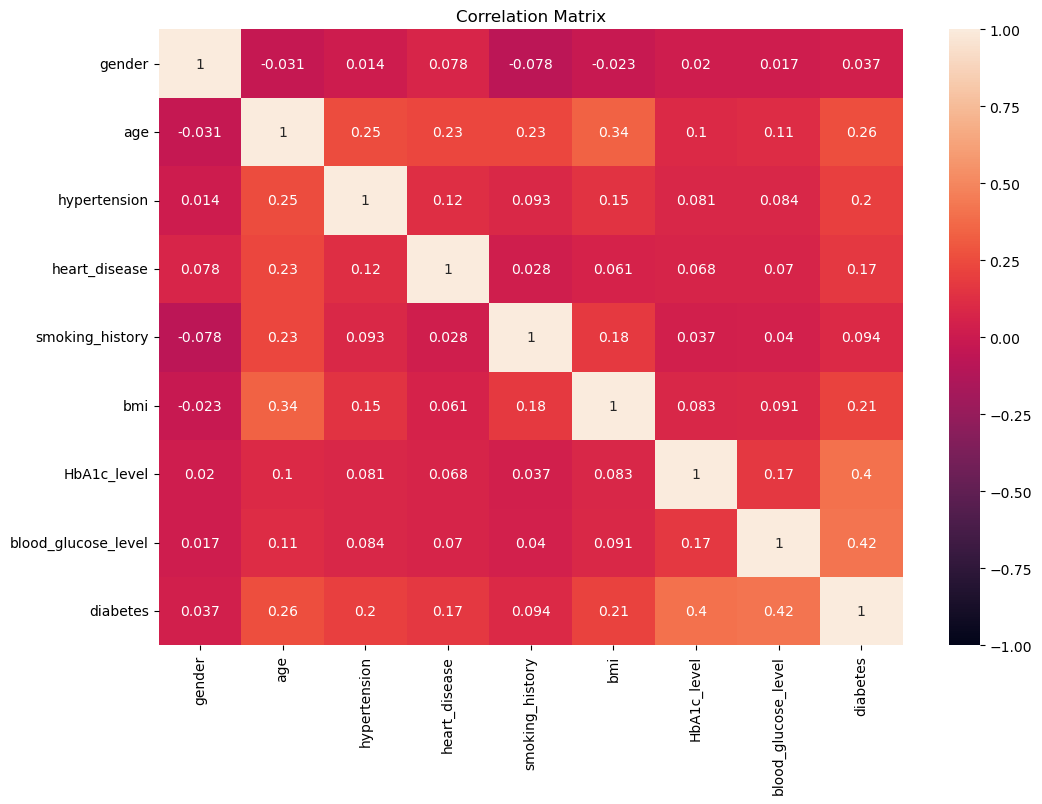

In [10]:
#Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = diabetes_df.corr()
sns.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

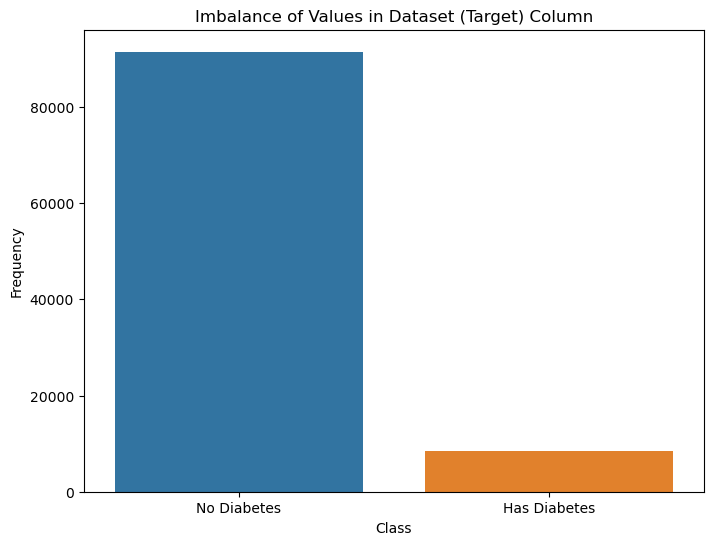

In [11]:
#Display class imbalance

#grab counts
counts = diabetes_df[diabetes_df.columns[-1]].value_counts()

# Plot the imbalance
plt.figure(figsize=(8, 6))
sns.barplot(x=counts.index, y=counts.values)
plt.title('Imbalance of Values in Dataset (Target) Column')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['No Diabetes', 'Has Diabetes'])
plt.show()

In [12]:
#Explore the data using visualization

#Pairplot
sns.pairplot(diabetes_df, hue='diabetes')
plt.suptitle('Pairplot of Features Colored by Dataset', y=1.02)
plt.show()


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x00000187C19E4900> (for post_execute):
Error in callback <function flush_figures at 0x00000187BEE49300> (for post_execute):



KeyboardInterrupt



KeyboardInterrupt: 

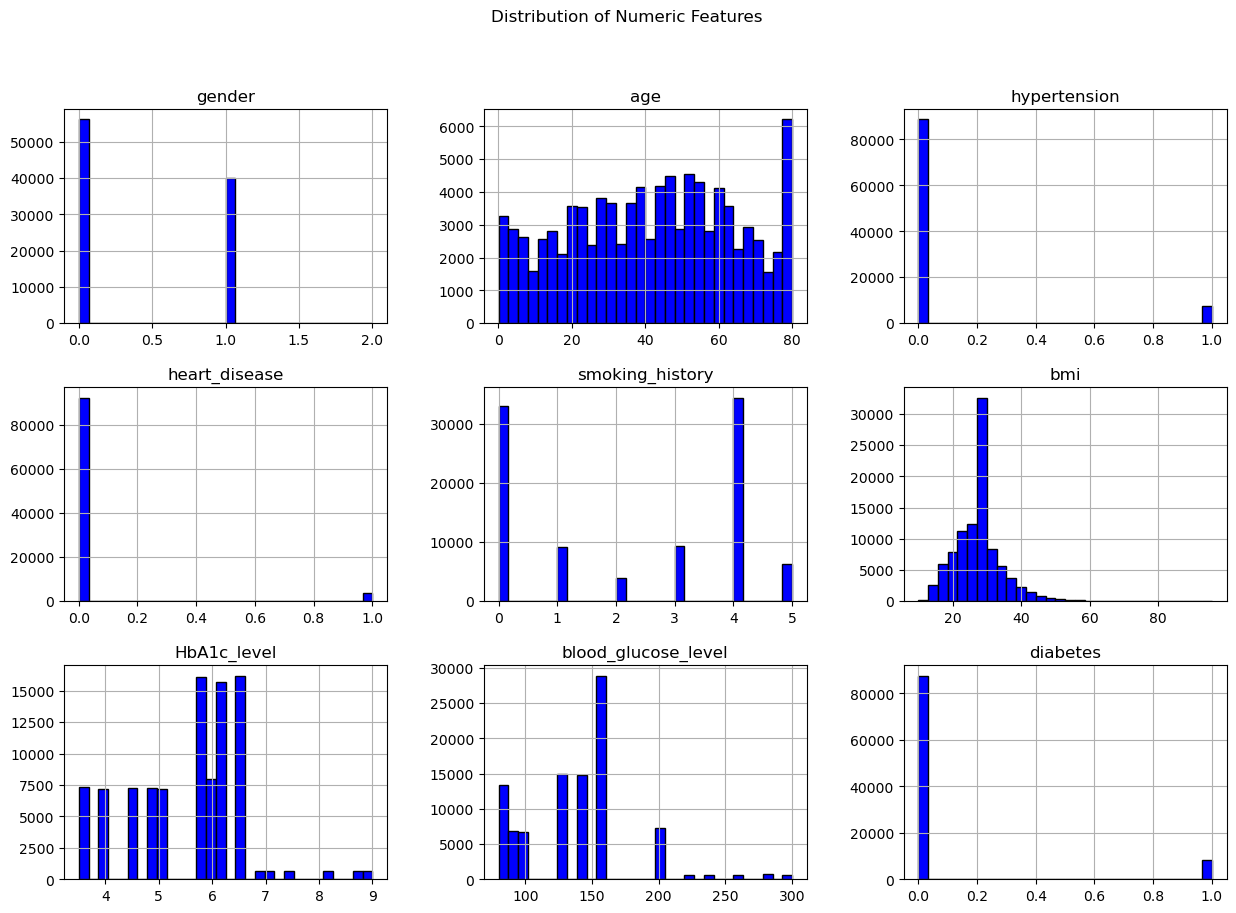

In [21]:
df = diabetes_df

# Distribution of numeric features
df.hist(bins=30, figsize=(15, 10), color='blue', edgecolor='black')
plt.suptitle('Distribution of Numeric Features')
plt.show()

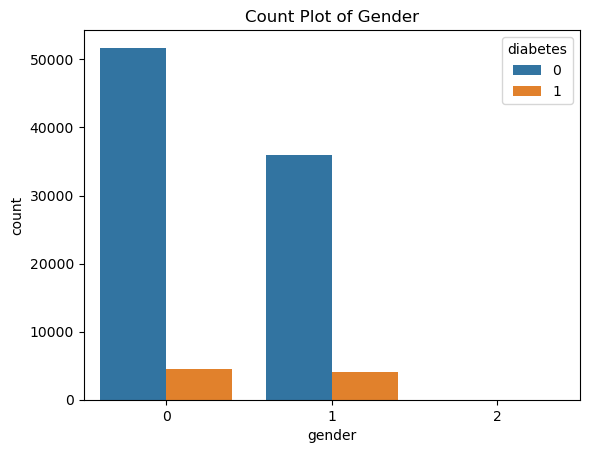

In [22]:
# Count plot for categorical features
categorical_features = ['gender']
for feature in categorical_features:
    sns.countplot(data=df, x=feature, hue='diabetes')
    plt.title(f'Count Plot of {feature.capitalize()}')
    plt.show()

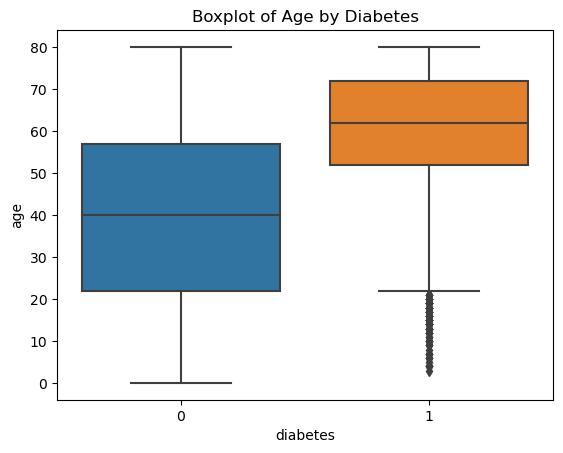

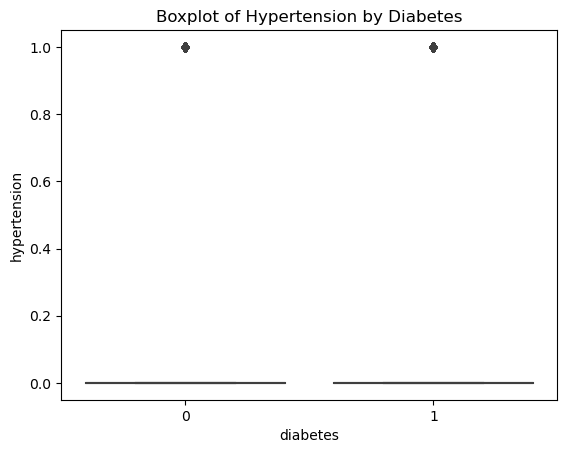

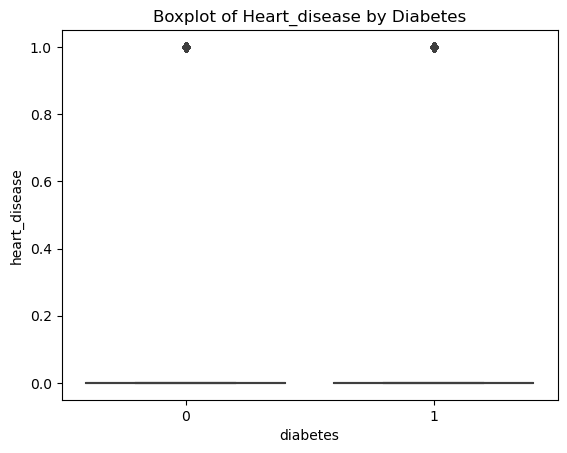

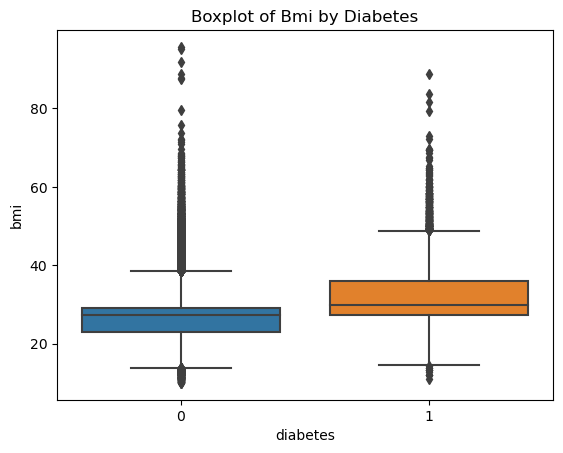

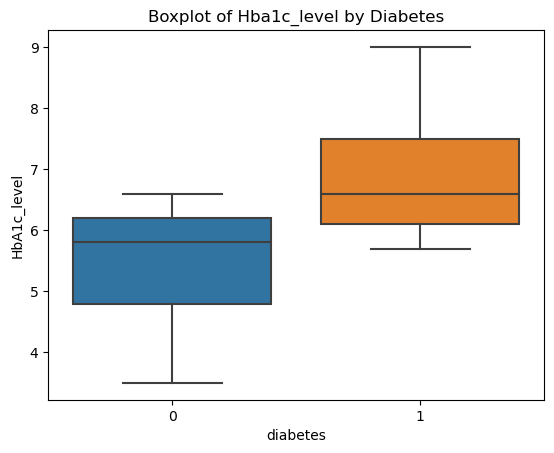

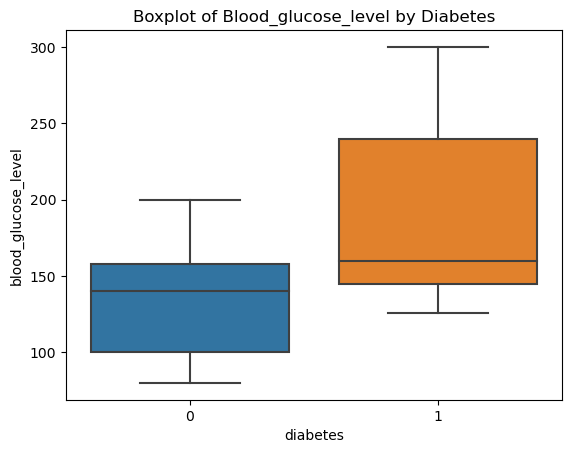

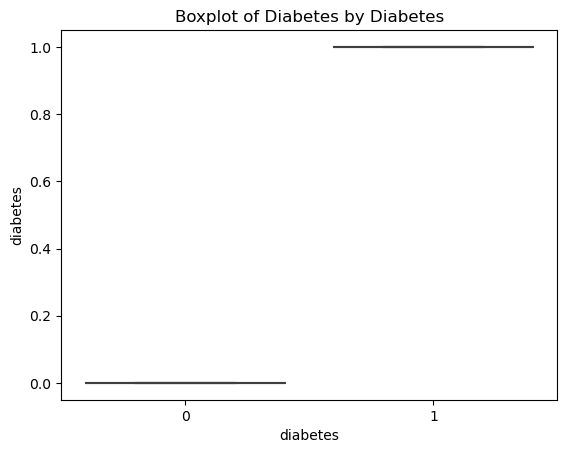

In [23]:
# Boxplots for continuous variables
continuous_features = df.select_dtypes(include=['float64', 'int64']).columns
for feature in continuous_features:
    sns.boxplot(x='diabetes', y=feature, data=df)
    plt.title(f'Boxplot of {feature.capitalize()} by Diabetes')
    plt.show()

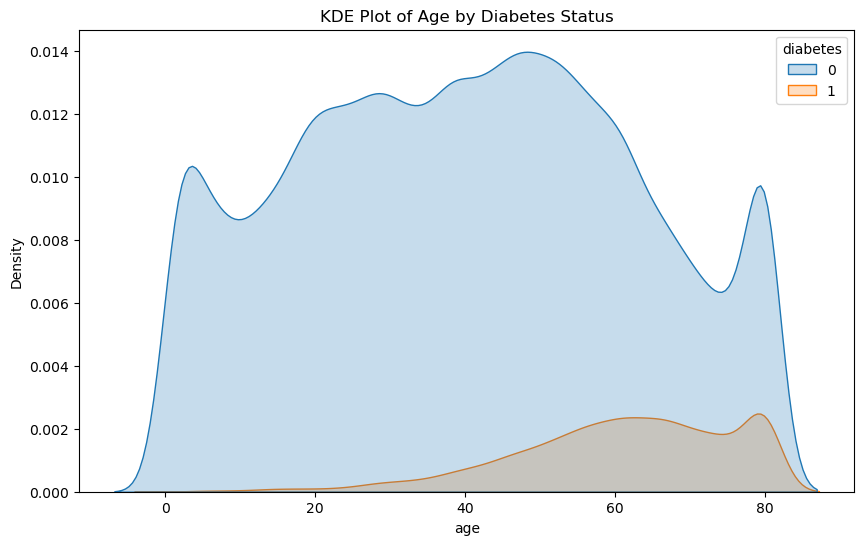

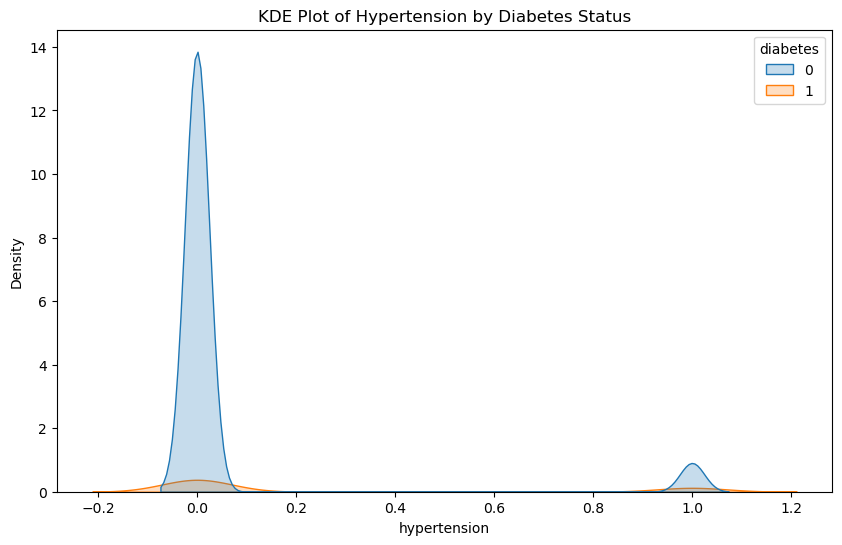

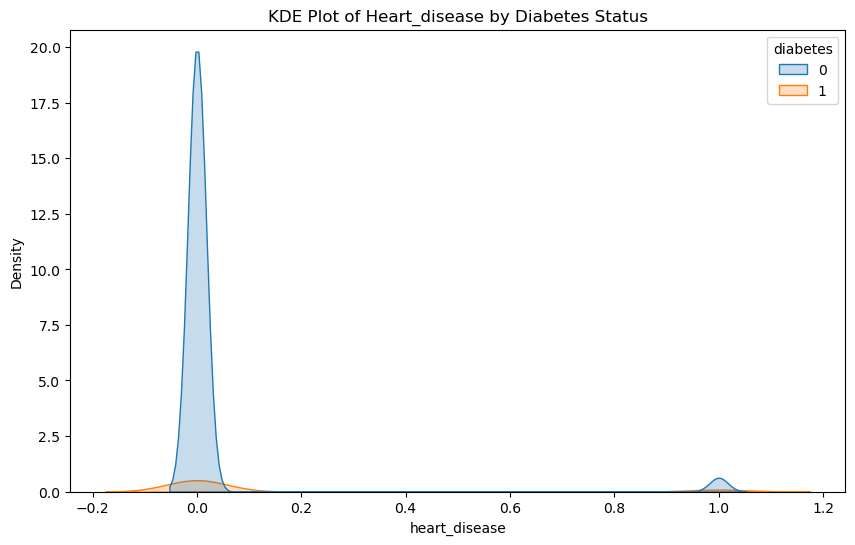

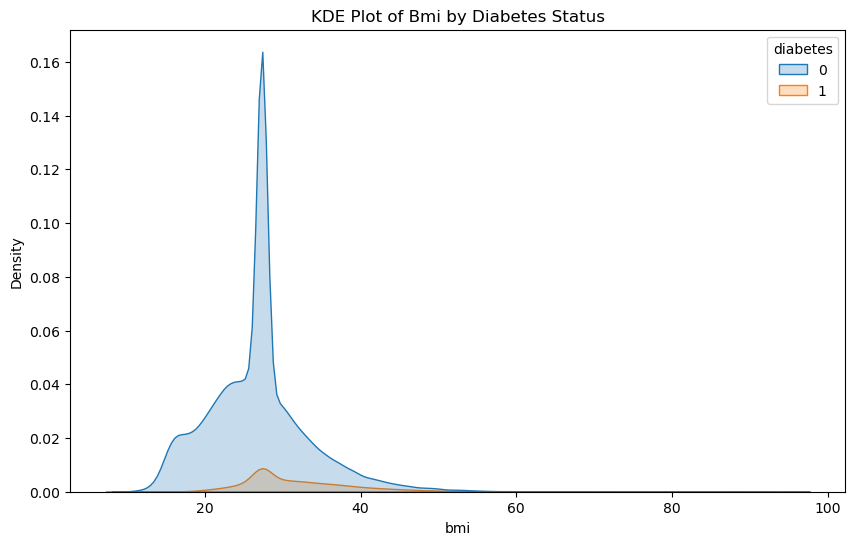

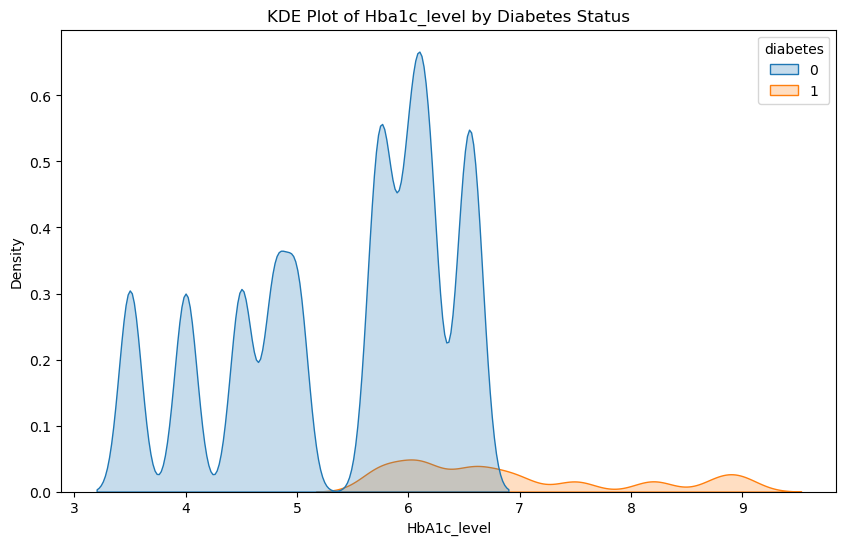

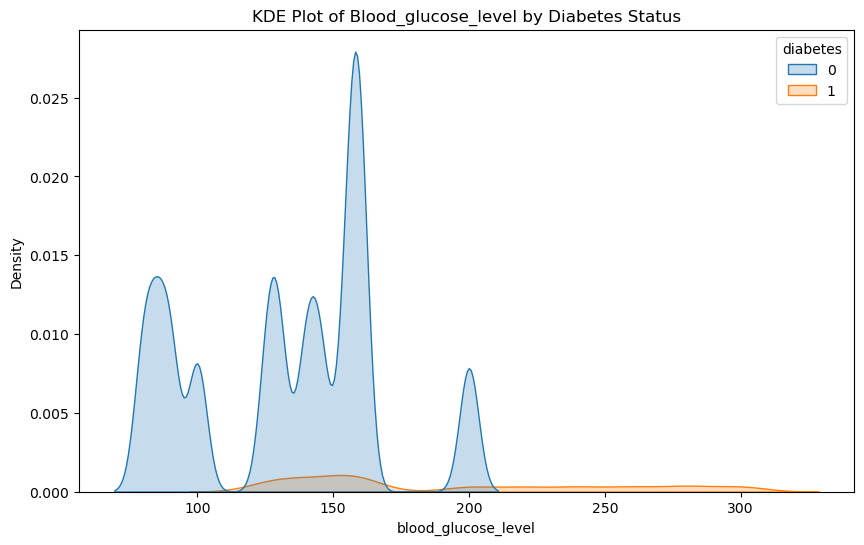

C:\Users\chris\AppData\Local\Temp\ipykernel_41908\128958497.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=feature, hue='diabetes', fill=True)


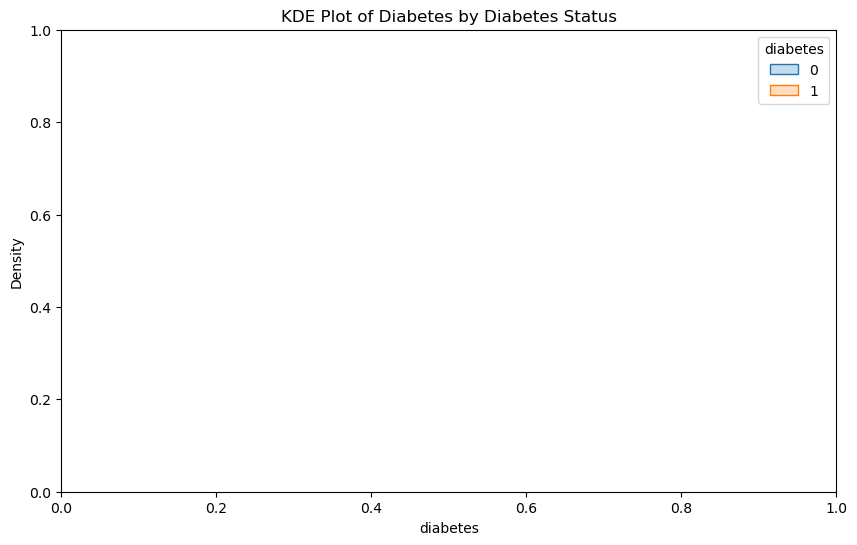

In [24]:
# KDE plot for continuous features by diabetes status
for feature in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x=feature, hue='diabetes', fill=True)
    plt.title(f'KDE Plot of {feature.capitalize()} by Diabetes Status')
    plt.show()

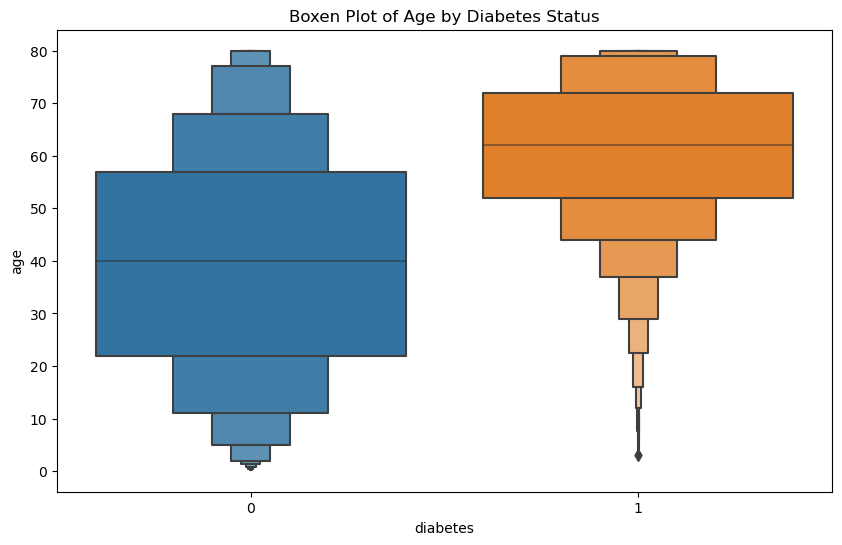

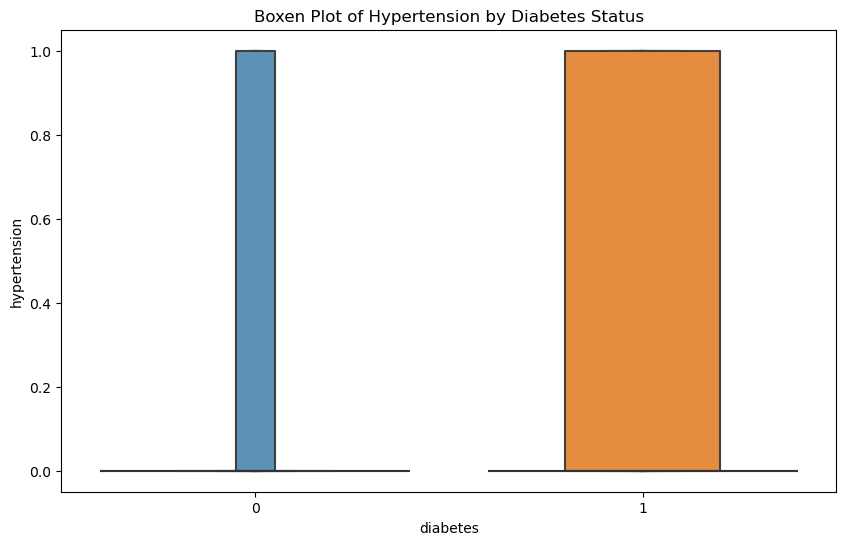

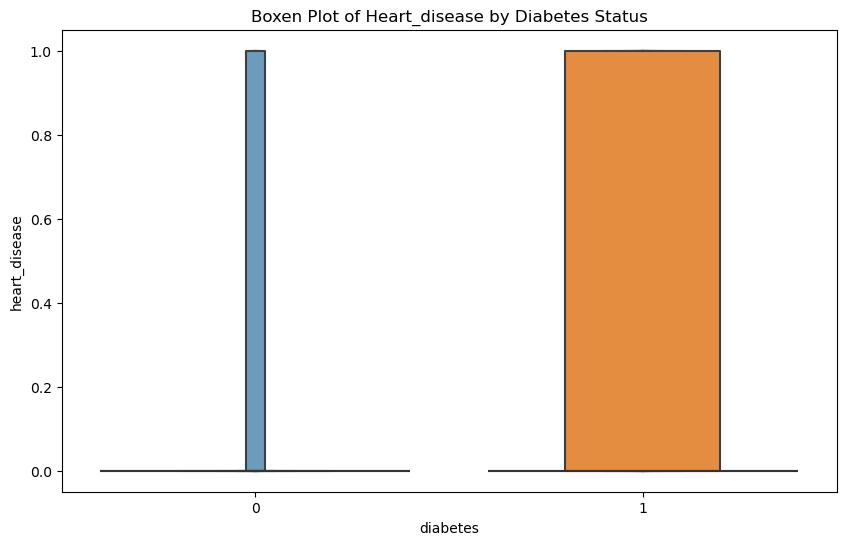

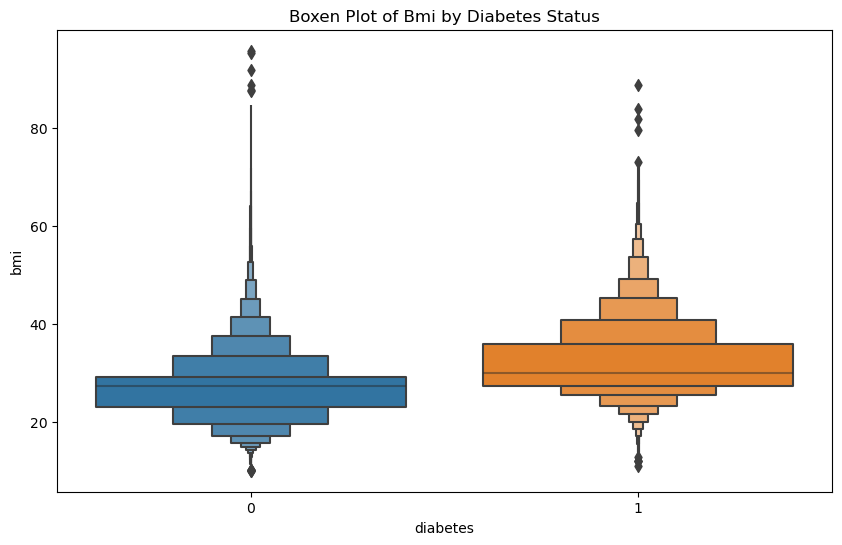

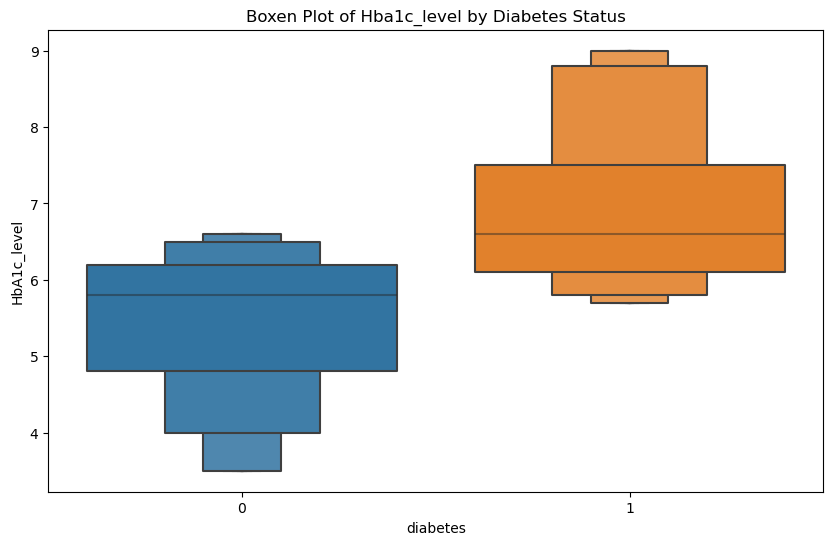

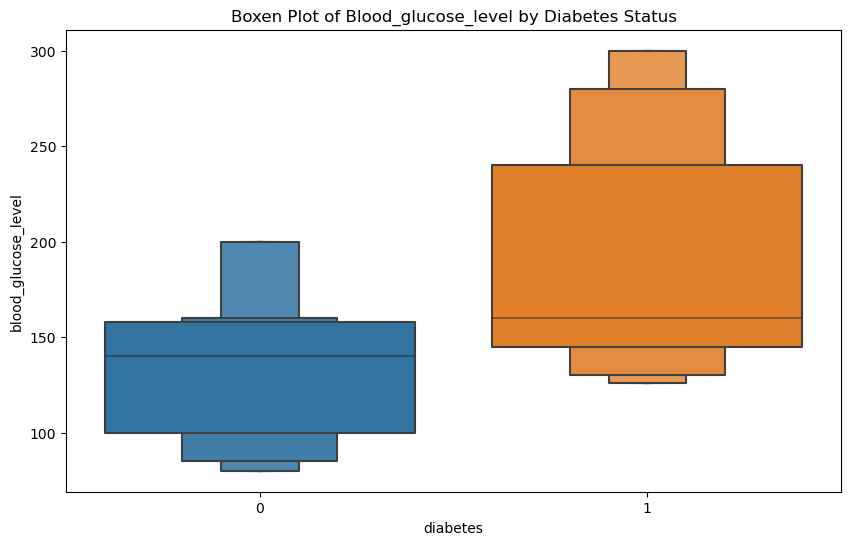

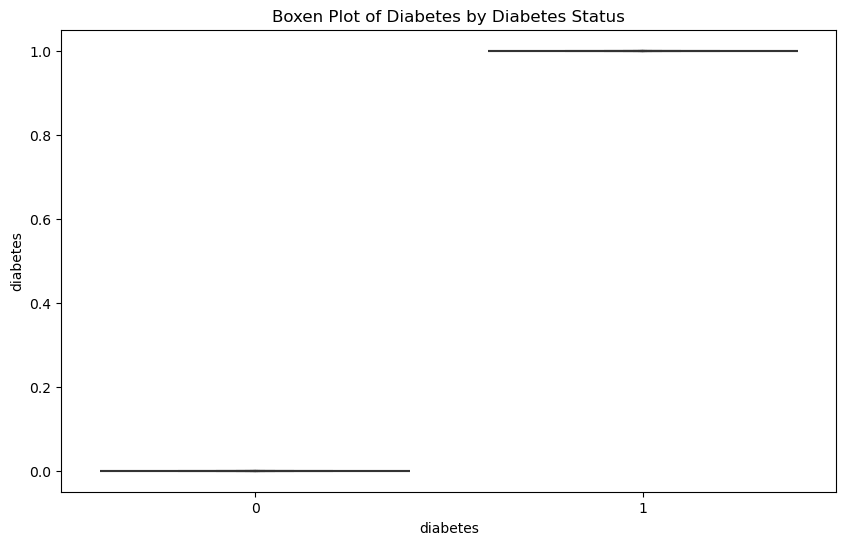

In [25]:
# Boxen plot for continuous features by diabetes status
for feature in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.boxenplot(x='diabetes', y=feature, data=df)
    plt.title(f'Boxen Plot of {feature.capitalize()} by Diabetes Status')
    plt.show()

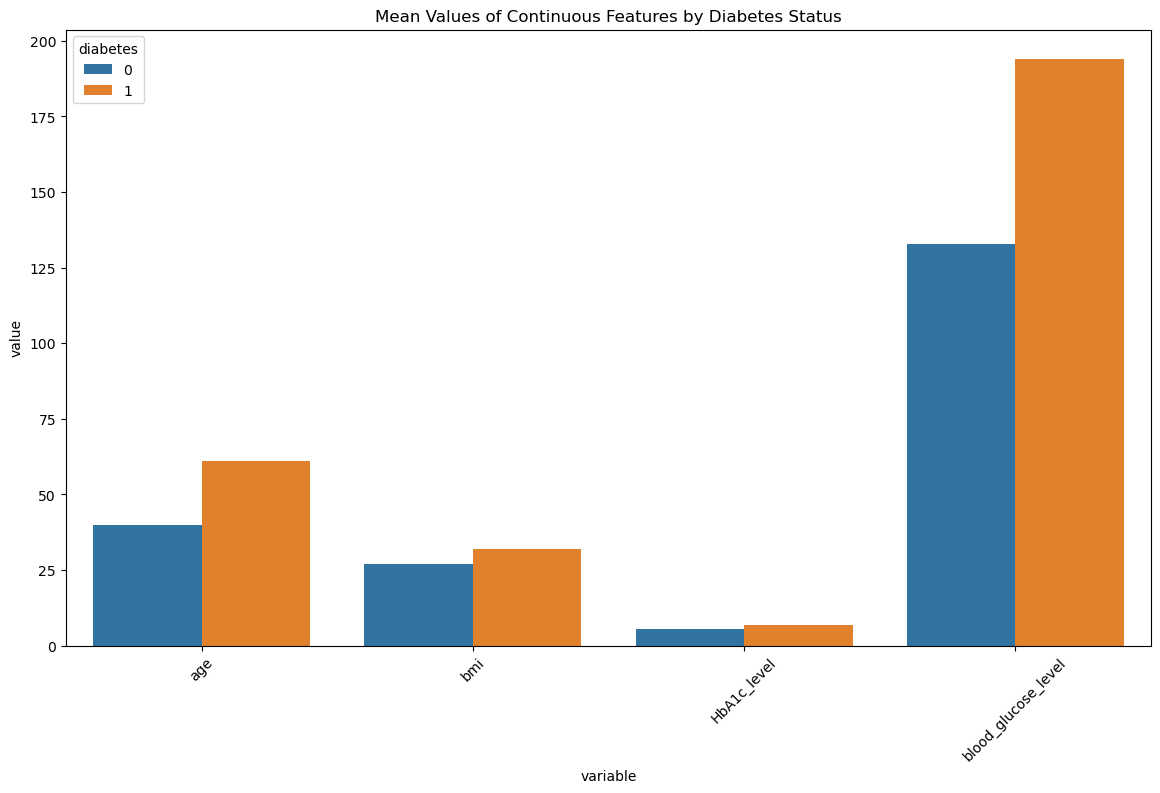

In [26]:
# Bar plot for mean values of continuous features grouped by diabetes status
grouped_means = df.groupby('diabetes').mean().reset_index()
grouped_means.drop(columns=['gender', 'hypertension', 'heart_disease', 'smoking_history'], inplace=True)
melted_grouped_means = pd.melt(grouped_means, id_vars='diabetes')
plt.figure(figsize=(14, 8))
sns.barplot(x='variable', y='value', hue='diabetes', data=melted_grouped_means)
plt.title('Mean Values of Continuous Features by Diabetes Status')
plt.xticks(rotation=45)
plt.show()

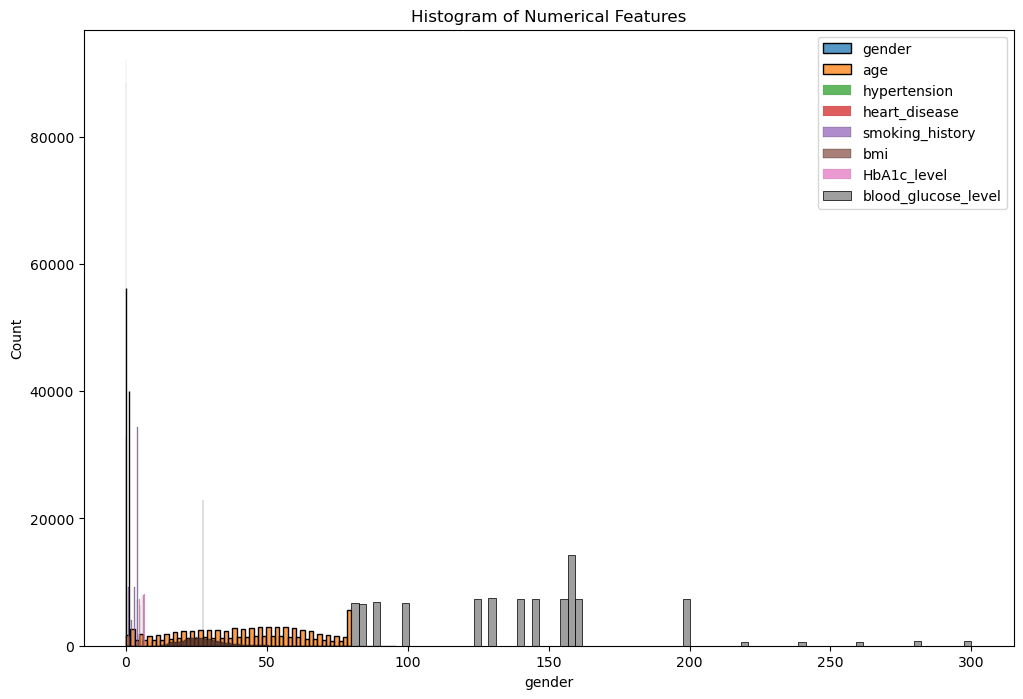

In [27]:
#histoplot
plt.figure(figsize=(12, 8))
for column in diabetes_df.columns[:-1]:  # Exclude the target column
    sns.histplot(diabetes_df[column], label=column)
plt.title('Histogram of Numerical Features')
plt.legend()
plt.show()

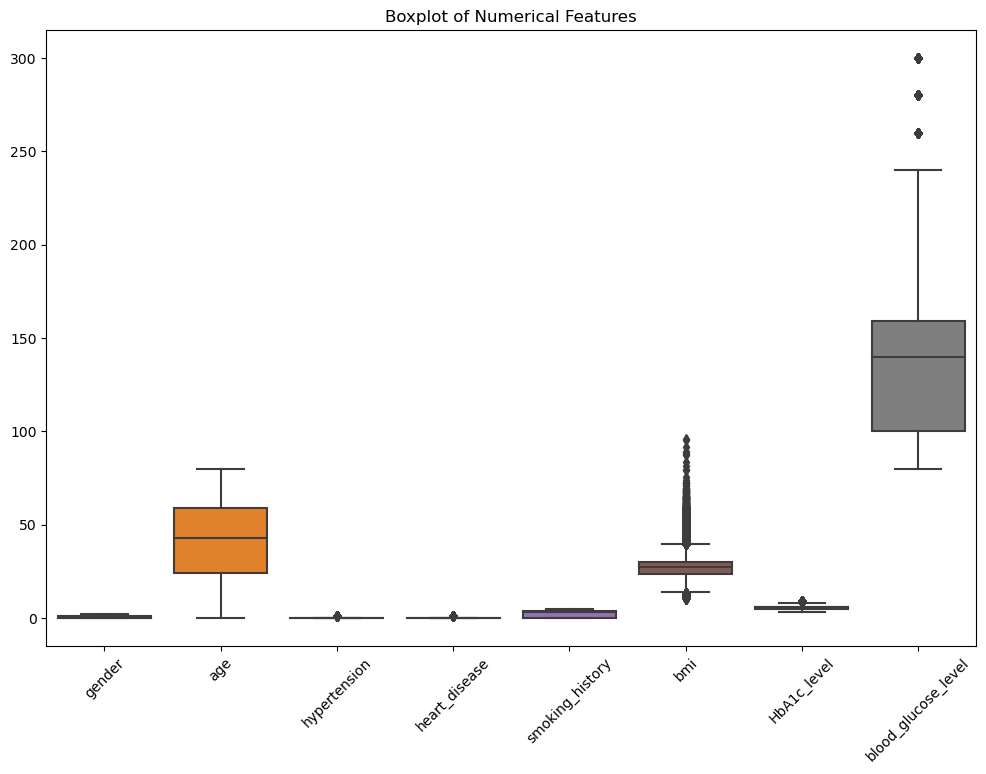

In [28]:
#Boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=diabetes_df.drop(columns=['diabetes']))
plt.title('Boxplot of Numerical Features')
plt.xticks(rotation=45)
plt.show()

## Preprocessing of Data

In [13]:
#Handle missing values
diabetes_df = diabetes_df.fillna(diabetes_df.median())

In [14]:
diabetes_df = diabetes_df.drop_duplicates(keep='first') # drops the duplicate entries in the data set

diabetes_df.duplicated().sum()

0

In [15]:
# This function removes anomalies from a dataset given a list of categories to check.
#
# Parameters:
# - Dataset,       type=pandas.dataframe
# - Categories,    type=list of strings
# - Quantile list, type=list of floats   (Optional, default=[0.25, 0.50, 0.75]) 
#
# Returns:
# - Dataset,    type=pandas.dataframe

def remove_anomalies(dataset, categories, quantile_list=[0.25, 0.50, 0.75]):
    # The quantiles are loaded from the quantile list.
    low = quantile_list[0]
    mid = quantile_list[1]
    top = quantile_list[2]
    
    # An empty dataset is initialized with the categories of the dataset.
    anomalies = pd.DataFrame(columns=categories)
    
    for category in categories:
        # Checks if the current category contains exclusively numerical data.
        # If the first entry in a category is a string, then that category is skipped to prevent a value error.
        try:
            if (type(dataset[category][0]) is str):
                continue
        except:
            pass
        
        # Calculating the quantiles.
        Q1 = dataset[category].quantile(0.25)
        Q2 = dataset[category].quantile(0.50)
        Q3 = dataset[category].quantile(0.75)
        IQR = Q3 - Q1

        # Calculating the bounds.
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        # Compiling the anomalies.
        current_anomaly = dataset[(dataset[category] < lower_bound) | (dataset[category] > upper_bound)]
        anomalies = pd.concat([anomalies, current_anomaly])
    
    # The anomalies are cleared of all duplicates.
    anomalies = anomalies.drop_duplicates()
    
    # The anomalies are removed from the dataset and returned for further use.
    dataset = dataset.drop(anomalies.index)
    
    return dataset

# This is an example on how to use the remove_anomalies function.  Note that this is commented out because I don't
# want to remove so many entries that it lobotomizes that models.
#
# The line of code below will remove all BMI anomalies from the diabetes dataframe.  Even if you want to remove
# anomalies from just one category, the category you want to remove must be in a list.
#remove_anomalies(diabetes_df, ["bmi"])

In [16]:
#splitting target from data
data = diabetes_df[diabetes_df.columns[:-1]]
target = diabetes_df[diabetes_df.columns[-1]]

In [17]:
from sklearn.preprocessing import StandardScaler 

# Initializes StandardScaler
scaler = StandardScaler()

# Fit and transform the data 
scaled_data = scaler.fit_transform(data)

In [18]:
pip install --upgrade scikit-learn

^C
Note: you may need to restart the kernel to use updated packages.


In [20]:
#Balance classes with SMOTE

import imblearn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
x,y = sm.fit_resample(scaled_data, target)

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (C:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

## Training the Models

In [ ]:
#Logistic regression
#Naives bayes
#KNN
#Random forest
#Decision tree
#Bagging
#AdaBoost
#XGBoost
#Voting
#SVM
#Neural Network
#Deep Neural Network

#Top Models we will run
#GridSearchCV
#RFE feature selection

### Standalone Models

In [ ]:
#Logistic Regression - Vance
from sklearn.linear_model import LogisticRegression

Logistic_regression_model = LogisticRegression(random_state=42).fit(X_train, y_train)

pred_log_reg = Logistic_regression_model.predict(X_test)

In [ ]:
#Naive Bayes - Jesus
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

pred_nb = nb_model.predict(X_test)

In [ ]:
#KNN - Joshua
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(weights='distance', algorithm='auto').fit(X_train, y_train)

pred_knn = knn_model.predict(X_test)

In [ ]:
#Random Forest - Joshua
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

pred_rfc = random_forest_model.predict(X_test)

In [ ]:
#SVM - Jesus 
from sklearn.svm import LinearSVC

svm_model = LinearSVC(random_state=42, dual=False)  # `dual=False` is preferable for cases where n_samples > n_features.

svm_model.fit(X_train, y_train)

pred_svm = svm_model.predict(X_test)


In [ ]:
#Decision Tree - Vance
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
decision_tree.fit(X_train,y_train)

pred_decision_tree = decision_tree.predict(X_test)

In [ ]:
#Neural Network
#https://keras.io/examples/structured_data/structured_data_classification_with_feature_space/
import keras
from keras import layers
from keras import ops, models, optimizers
from keras.utils import FeatureSpace

# Assuming X_train, y_train, X_test, y_test are already defined and preprocessed
input_shape = X_train.shape[1:]

simple_NN = models.Sequential(
    [
    layers.Input(shape=input_shape),
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # For binary classification
    ]
)

simple_NN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
simple_NN.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Make predictions
pred_simple_NN = simple_NN.predict(X_test)

pred_simple_NN = (pred_simple_NN > 0.5).astype(int)

### Combination Models

In [ ]:
#Bagging - David Visbal Gomez
from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier()
bagging_model.fit(X_train, y_train)

pred_bagging = bagging_model.predict(X_test)

In [ ]:
#AdaBoost - David Visbal Gomez
from sklearn.ensemble import AdaBoostClassifier

ada_boost_model = AdaBoostClassifier(algorithm='SAMME')
ada_boost_model.fit(X_train, y_train)

pred_ada_boost = ada_boost_model.predict(X_test)

In [ ]:
#GBoost - Vance
from sklearn.ensemble import GradientBoostingClassifier

gboost_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
gboost_model.fit(X_train, y_train)

pred_gradient_boost = gboost_model.predict(X_test)

In [ ]:
#XGBoost - Vance
from xgboost import XGBClassifier

xgboost_model = XGBClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
xgboost_model.fit(X_train, y_train)

pred_xgboost = xgboost_model.predict(X_test)

In [ ]:
#Voting - David Visbal Gomez
from sklearn.ensemble import VotingClassifier

# The estimators for the voting model are taken from previous models.
# To be specific: logistic regression, naive bayes, and decision trees are used for the voting model.
voting_model = VotingClassifier(
    estimators=[
        ("lr", Logistic_regression_model), 
        ("nb", nb_model), 
        ("knn", knn_model),
        ("svm", svm_model)], 
    voting="hard")

voting_model.fit(X_train, y_train)

pred_voting = voting_model.predict(X_test)

In [ ]:
#Advanced Neural Network - Vance

# Assuming X_train, y_train, X_test, y_test are already defined and preprocessed
input_shape = X_train.shape[1:]

reduce_lr_callback =  keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,                    
    patience=2, 
    min_lr=1e-6,
    verbose=1,
)

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

deep_NN = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(1, activation="sigmoid")  # For binary classification
])

deep_NN.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
deep_NN.fit(
    X_train, y_train, 
    batch_size=32, 
    epochs=50, 
    validation_data=(X_test, y_test), 
    callbacks=[reduce_lr_callback, early_stopping_callback])

deep_NN.evaluate(X_test, y_test)

# Make predictions
pred_deep_NN = deep_NN.predict(X_test)

pred_deep_NN = (pred_deep_NN > 0.5).astype(int)

## Comparing the Models

https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, matthews_corrcoef

def evaluate(y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    mtc = matthews_corrcoef(y_test, y_pred)

    results = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'AUC': auc,
        #'Matthews Corr Coef': mtc,
    }

    return results

def displayCM(y_pred):
    # Generate matrix
    cm = confusion_matrix(y_test, y_pred)
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Diabetes (1)', 'No Diabetes (0)'])
    disp.plot()
    plt.title('Confusion Matrix Tree')
    plt.show()

def displayResultsTable(modelResults):
    df = pd.DataFrame(modelResults).T
    print(df)

def findTopModels(modelResults, metricName, top_n=5):
    # Create a list of tuples with (model_name, metric_score)
    scores = [(model_name, metrics[metricName]) for model_name, metrics in modelResults.items()]
    
    # Sort the list by metric score in descending order
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    
    # Get the top_n models
    top_models = sorted_scores[:top_n]
    
    return top_models

In [ ]:
logistic_regression = evaluate(pred_log_reg)
decision_tree = evaluate(pred_decision_tree)
KNN = evaluate(pred_knn)
random_forest = evaluate(pred_rfc)
neural_network = evaluate(pred_simple_NN)
deep_neural_network = evaluate(pred_deep_NN)
svm = evaluate(pred_svm)
naive_bayes = evaluate(pred_nb)

gboost = evaluate(pred_gradient_boost)
xgboost = evaluate(pred_xgboost)

# David Visbal Gomez's Models' Results
bagging = evaluate(pred_bagging)
ada_boost = evaluate(pred_ada_boost)
voting = evaluate(pred_voting)

modelResults = {
    'Logistic Regression': logistic_regression,
    'Naive Bayes': naive_bayes,
    'KNN': KNN,
    'Random Forest': random_forest,
    'Decision Tree': decision_tree,
    'Bagging': bagging,
    'AdaBoost': ada_boost,
    'Gradient Boost': gboost,
    'Extreme Gradient Boost': xgboost,
    'Voting': voting,
    'SVM': svm,
    'Neural Network': neural_network,
    'Deep Neural Network': deep_neural_network,
}

displayResultsTable(modelResults)

top_f1_models = findTopModels(modelResults,'F1')
print()
print(f'The model with the highest F1 score is {top_f1_models[0][0]} with a score of {top_f1_models[0][1]:.4f}')
print()
print("Top 5 models based on F1 score:")
for model_name, score in top_f1_models:
    print(f'{model_name}: {score:.4f}')

top_acc_models = findTopModels(modelResults,'Accuracy')
print()
print(f'The model with the highest accuracy score is {top_acc_models[0][0]} with a score of {top_acc_models[0][1]:.4f}')
print()
print("Top 5 models based on Accuracy score:")
for model_name, score in top_acc_models:
    print(f'{model_name}: {score:.4f}')

top_AUC_models = findTopModels(modelResults,'AUC')
print()
print(f'The model with the highest AUC score is {top_AUC_models[0][0]} with a score of {top_AUC_models[0][1]:.4f}')
print()
print("Top 5 models based on AUC score:")
for model_name, score in top_AUC_models:
    print(f'{model_name}: {score:.4f}')

## Feature Selection & GridSearchCV on the Top Model

In [ ]:
print("Starting number of features: 8")

In [ ]:
#Feature Selection using top model Random Forest
from sklearn.feature_selection import RFECV

random_forest_rfe = RFECV(random_forest_model, scoring='f1')
random_forest_rfe.fit(X_train, y_train)

X_train_selected = random_forest_rfe.transform(X_train)
X_test_selected = random_forest_rfe.transform(X_test)

print("Optimal number of features: %d" % random_forest_rfe.n_features_)
print("Selected features: %s" % random_forest_rfe.support_)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

random_forest_model = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=random_forest_model, param_grid=param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_selected, y_train)

best_params_rf = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_

print("Best parameters for Random Forest: ", best_params_rf)

In [ ]:
param_grid_bagging = {
    'n_estimators': [10, 50],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

grid_search_bagging = GridSearchCV(estimator=bagging_model, param_grid=param_grid_bagging, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_bagging.fit(X_train_selected, y_train)
best_params_bagging = grid_search_bagging.best_params_
best_bagging_model = grid_search_bagging.best_estimator_
print("Best parameters for Bagging: ", best_params_bagging)


In [ ]:
param_grid_knn = {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(estimator=knn_model, param_grid=param_grid_knn, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train_selected, y_train)
best_params_knn = grid_search_knn.best_params_
best_knn_model = grid_search_knn.best_estimator_
print("Best parameters for KNN: ", best_params_knn)


In [ ]:
pred_rf_best = best_rf_model.predict(X_test_selected)
pred_bagging_best = best_bagging_model.predict(X_test_selected)
pred_knn_best = best_knn_model.predict(X_test_selected)

random_forest = evaluate(pred_rf_best)
bagging = evaluate(pred_bagging_best)
KNN = evaluate(pred_knn_best)

modelResults2 = {
    'Random Forest': random_forest,
    'Bagging': naive_bayes,
    'KNN': KNN,
}


In [ ]:
displayResultsTable(modelResults)